In [1]:
# データインポートライブラリ
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import warnings
import requests
import zipfile
import io
import re as re
import string

# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import pandas as pd
import sweetviz as sv


# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline


%precision 3

warnings.filterwarnings('ignore')

SEED = 42


In [2]:
import scipy as sp
from pandas import Series, DataFrame
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import pandas as pd
import sweetviz as sv


# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline


%precision 3

warnings.filterwarnings('ignore')

SEED = 42


In [3]:
#Function
def concat_df(train_data, test_data, sort=True, drop=True):
    """
    overview
    >return a  concatenated df of training and test data
    needed
    >pandas as pd
    input
    >train_data{DataFrame}:train_data
    >test_data{DataFrame}:test_data
    >sort{bool}:True or False
    """
    return pd.concat([train_data, test_data], sort=sort).reset_index(drop=drop)


def divide_df(all_data, target, len=890):
    """
    overview
    > Returns divided dfs of training and test set
    needed
    >
    input
    > all_data{DataFrame}:Train+Test
    > target{str} :Target columns
    > len(int):len of train_data
    
    """
    return all_data.loc[:len], all_data.loc[len:].drop([target], axis=1)

In [4]:
df_train = pd.read_csv("./df/EDA_05_train.csv")
df_test = pd.read_csv("./df/EDA_05_test.csv")
Target = 'Survived'
Final_target = 'Perished'
df_test.shape

(418, 44)

In [5]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', Target,
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
             'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [6]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train[Target].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))


X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [7]:
single_best_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)


In [8]:
model = single_best_model
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=[
                     'Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=[
                           'Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))

    # Fitting the model
    model.fit(X_train[trn_idx], y_train[trn_idx])

    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(
        y_train[trn_idx], model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(
        y_train[val_idx], model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(
        fold)] = model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(
        fold)] = model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = model.feature_importances_

    oob += model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, model.oob_score_))

print('Average OOB Score: {}'.format(oob))


Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 1 OOB Score: 0.8553370786516854

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 2 OOB Score: 0.847124824684432

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 3 OOB Score: 0.8541374474053296

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 4 OOB Score: 0.8373071528751753

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 5 OOB Score: 0.8316970546984572

Average OOB Score: 0.8451207116630157


[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished


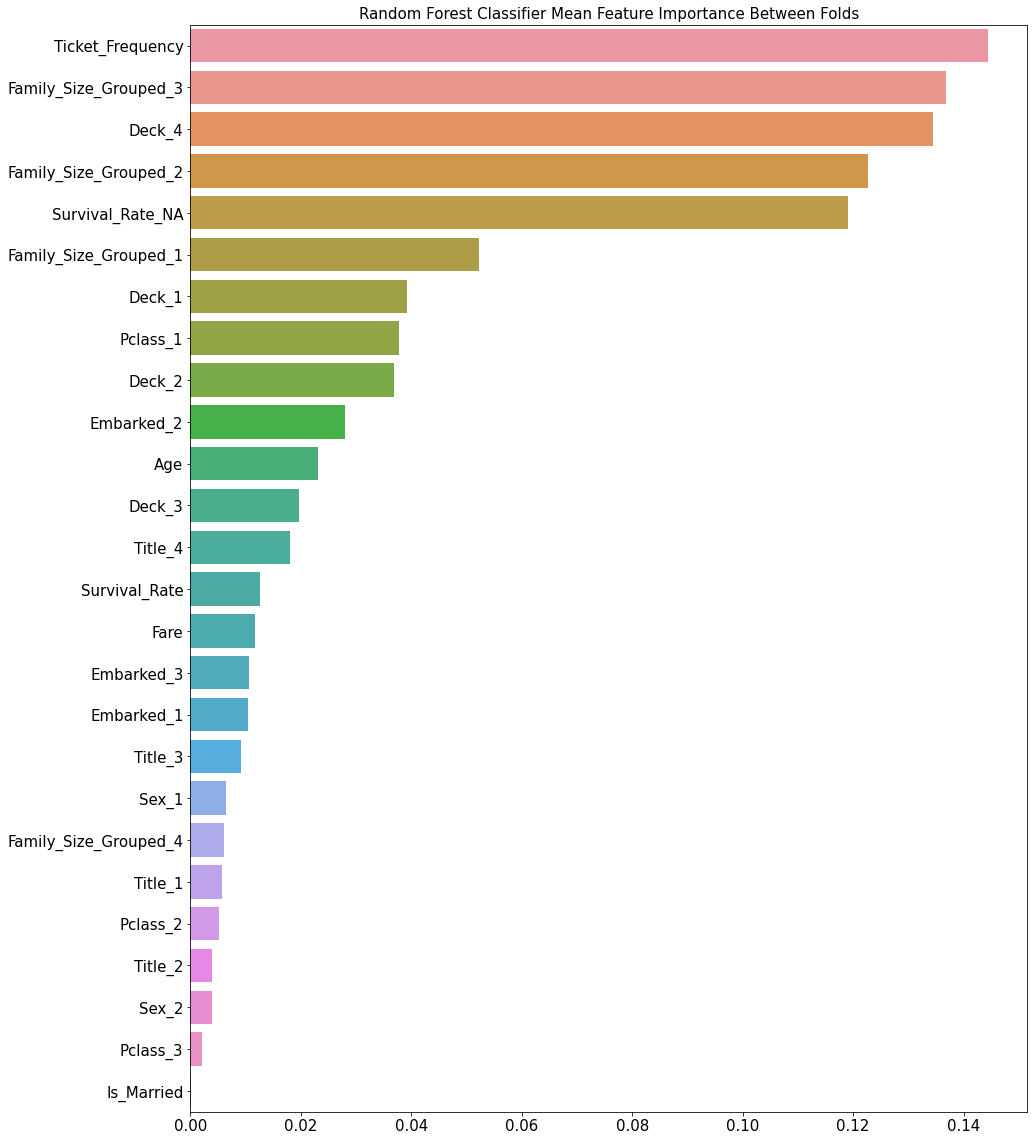

In [9]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

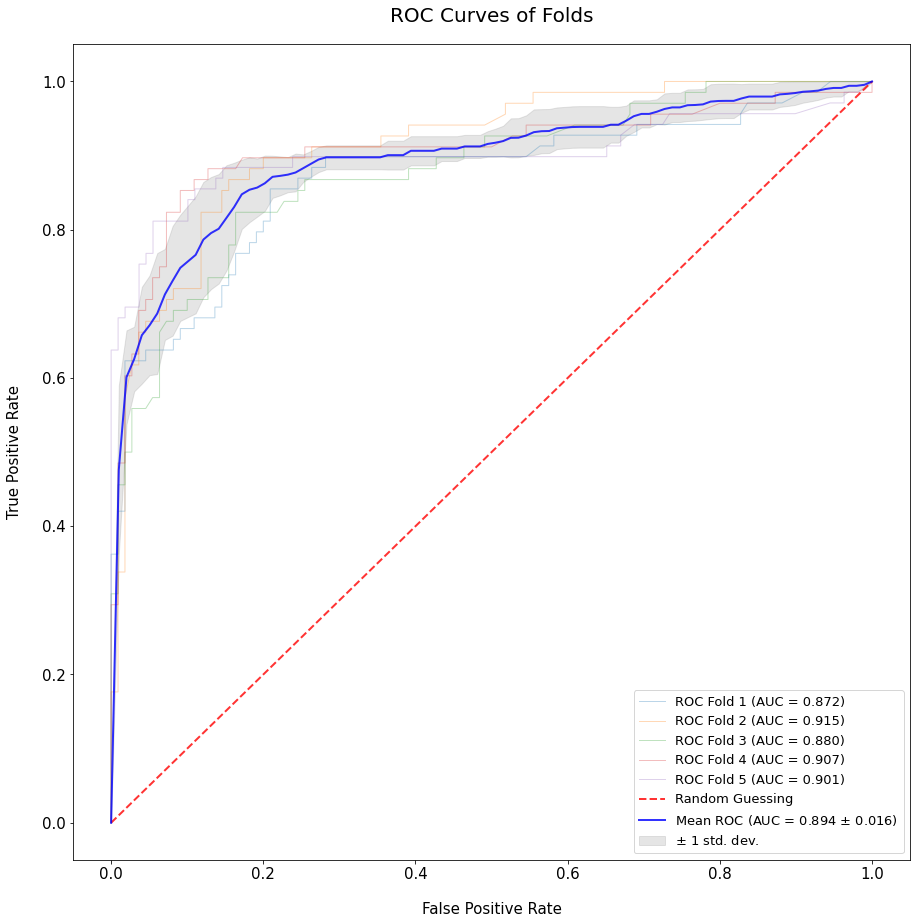

In [10]:
def plot_roc_curve(fprs, tprs):

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))

    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))

    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='r', alpha=0.8, label='Random Guessing')

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(
        mean_auc, std_auc), lw=2, alpha=0.8)

    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                    color='grey', alpha=.2, label='$\pm$ 1 std. dev.')

    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})

    plt.show()


plot_roc_curve(fprs, tprs)


In [21]:
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
Pick_up_Model = [
    discriminant_analysis.LinearDiscriminantAnalysis(),
    XGBClassifier(),
    ensemble.GradientBoostingClassifier(),
]
i = 0
cv_split = model_selection.ShuffleSplit(
    n_splits=10, test_size=.3, train_size=.6, random_state=0)

Model1 = Pick_up_Model[0]
cv_results = model_selection.cross_validate(
    Model1, X_train, y_train, cv=cv_split, return_train_score=True,return_estimator=True)
Model1.fit(X_train, y_train)
print(Model1.score(X_train,y_train))
Model1_pred = Model1.predict_proba(X_test)

Model2 = Pick_up_Model[1]
cv_results = model_selection.cross_validate(
    Model2, X_train, y_train, cv=cv_split, return_train_score=True)
Model2.fit(X_train, y_train)
Model2_pred = Model2.predict_proba(X_test)
print(Model2.score(X_train, y_train))
Model3 = Pick_up_Model[2]
cv_results = model_selection.cross_validate(
    Model3, X_train, y_train, cv=cv_split, return_train_score=True)
Model3.fit(X_train, y_train)
Model3_pred = Model3.predict_proba(X_test)
print(Model3.score(X_train, y_train))


0.8529741863075196
0.9450056116722784
0.9012345679012346


In [13]:
type(Model1_pred)

numpy.ndarray

In [14]:
Model3_pred.argmax(axis=1)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['0'] = probs[class_survived].sum(axis=1) / N
probs['1'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)
submission_ex = pd.read_csv("gender_submission.csv")
submission_df = pd.DataFrame(columns=['PassengerId', Final_target])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df[Final_target] = y_pred.values
submission_df.reset_index(drop=True,inplace=True)
submission_df.to_csv('sub/05_submissions_kaggle.csv', header=True, index=False)
print("Submission Format:{} ".format(submission_ex.shape))
print("My Sumbisison Format:{}".format(submission_df.shape))
submission_df


In [73]:
Perished_count = len(submission_df[submission_df['Perished'] == 1])
All_count = len(submission_df)
print("Perished % = {}".format(Perished_count/All_count * 100))

Perished % = 81.3397129186603
